In [19]:
# インストール（Google Colabで実行する場合、このセルを実行してください）
# !pip -q install pymc pytensor dwave-neal tqdm matplotlib

## 問題設定

- 決定変数：$x\in\{0,1\}^d$
- ブラックボックス：$f(x)=x^T Q x$
- 目標：$f(x)$ を小さくする $x$ を探索

ブラックボックスは「評価できるだけ」で、勾配や構造を直接使えない想定です。

In [20]:
import numpy as np

class QuadraticBlackbox:
    """二次形式のブラックボックス関数 f(x)=x^T Q x を提供するクラス。"""

    def __init__(self, d: int, seed: int = 1234):
        """乱数で対称行列 Q を生成して保持する（seedで再現可能）。"""
        self.d = int(d)
        self.seed = int(seed)

        rng = np.random.default_rng(self.seed)
        Q = rng.random((self.d, self.d))
        Q = (Q + Q.T) / 2.0   # 対称化
        Q = Q - np.mean(Q)    # 中心化（平均を0付近に）
        self.Q = Q.astype(np.float64)

    def __call__(self, x: np.ndarray) -> float:
        """単一のバイナリベクトル x（shape=(d,)）を評価して f(x) を返す。"""
        x = np.asarray(x, dtype=np.float64)
        assert x.shape == (self.d,)
        return float(x @ self.Q @ x)

    def batch(self, X: np.ndarray) -> np.ndarray:
        """複数の候補 X（shape=(N,d)）を一括で評価して f(x) の配列を返す。"""
        X = np.asarray(X, dtype=np.float64)
        assert X.ndim == 2 and X.shape[1] == self.d
        Y = np.sum((X @ self.Q) * X, axis=1)  # diag(X Q X^T) の計算
        return Y.astype(np.float32)

    def as_qubo_dict(self, tol: float = 0.0) -> dict:
        """QUBO辞書形式 {(i,j):係数} に変換する（上三角のみ、tol以下は省略）。"""
        Qd = {}
        for i in range(self.d):
            v = float(self.Q[i, i])
            if abs(v) > tol:
                Qd[(i, i)] = v
        ii, jj = np.triu_indices(self.d, 1)
        for i, j in zip(ii, jj):
            v = float(self.Q[i, j])
            if abs(v) > tol:
                Qd[(i, j)] = v
        return Qd

In [21]:
import numpy as np

class RNG:
    """再現性のある乱数生成のためのユーティリティクラス。"""

    def __init__(self, seed=0):
        """seed を固定して乱数生成器を初期化する。"""
        self.rng = np.random.default_rng(int(seed))

    def bits(self, n, d):
        """{0,1} のバイナリ行列（shape=(n,d)）を生成する。"""
        return self.rng.integers(0, 2, size=(int(n), int(d)), dtype=np.int8)

    def randint(self, low, high):
        """[low, high) の整数乱数を1つ生成する。"""
        return int(self.rng.integers(low, high))

## 代理モデル：Factorization Machine（FM）

FMは、バイナリ特徴量 $x$ に対して

$$
\hat{y}(x) = w_0 + \sum_i w_i x_i + \sum_{i<j} \langle v_i, v_j \rangle x_i x_j
$$

の形で回帰します。

- $w_0$：バイアス
- $w_i$：一次係数
- $v_i \in \mathbb{R}^k$：相互作用の「潜在ベクトル」
- $\langle v_i, v_j\rangle$：二次係数を低ランク構造で表現

ポイントは、二次項の係数行列をフルに持つ代わりに、$k$ 次元の潜在表現で近似することです（パラメータ数を抑えられる）。


## Bayesian化（不確実性を持つ回帰）

FMのパラメータを確率変数として扱い、観測 $y$ を

$$
y \sim \mathcal{N}(\hat{y}(x), \sigma)
$$

でモデル化します。事前分布は（簡略化して）

- $w_0 \sim \mathcal{N}(0, 2)$
- $w_i \sim \mathcal{N}(0, \sigma_w)$
- $v_{i,f} \sim \mathcal{N}(0, \sigma_v)$
- $\sigma \sim \mathrm{HalfNormal}(\sigma_\mathrm{noise})$

のように置きます。

このノートでは **ADVI**（変分推論）で事後分布を近似し、そこからサンプルを取り出します。

In [22]:
import numpy as np
import pytensor.tensor as pt
import pymc as pm
from pytensor import shared

class BayesianFM_VI:
    """Bayesian Factorization Machine を PyMC + ADVI（VI）で学習するクラス。"""

    def __init__(self, d, k, max_samples, w_sigma=1.0, v_sigma=0.1, noise_sigma=1.0):
        """モデルを構築し、後からデータを差し替えられるよう shared を用意する。"""
        self.d = int(d)
        self.k = int(k)
        self.max_samples = int(max_samples)

        self.x_shared = shared(np.zeros((max_samples, d), dtype=np.float32), name="x_shared")
        self.y_shared = shared(np.zeros((max_samples,), dtype=np.float32), name="y_shared")
        self.n_shared = shared(0, name="n_shared")

        # --- ここで Bayesian FM（BFM）を定義する（PyMCの確率モデル）---
        with pm.Model() as self.model:
            # 1) 事前分布：FMのパラメータ（w0, w, v）と観測ノイズ（sigma）
            w0 = pm.Normal("w0", 0.0, 2.0)                    # バイアス
            w  = pm.Normal("w",  0.0, w_sigma, shape=(d,))    # 一次係数
            v  = pm.Normal("v",  0.0, v_sigma, shape=(d, k))  # 二次相互作用の潜在ベクトル
            sigma = pm.HalfNormal("sigma", noise_sigma)       # 観測ノイズ（正）

            # 2) 観測データ：shared から「有効な n_shared 個」だけを使う
            X = self.x_shared[:self.n_shared]  # shape: (n, d)
            y = self.y_shared[:self.n_shared]  # shape: (n,)

            # 3) FMの予測式：mu = w0 + Xw + 二次相互作用
            linear = w0 + pt.dot(X, w)
            inter = 0.5 * (pt.sum(pt.dot(X, v)**2, axis=1) - pt.sum(pt.dot(X**2, v**2), axis=1))
            mu = linear + inter

            # 4) 尤度：y は N(mu, sigma) に従う（回帰）
            pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)
        # --- ここまでが Bayesian FM（BFM）の定義 ---

        self.approx = None
        self.samples = None

    def fit(self, X, y, iters=8000, draws=100, seed=0):
        """ADVIで学習し、事後分布からサンプルを生成する。"""
        n = X.shape[0]
        self.x_shared.set_value(np.pad(X.astype(np.float32), ((0, self.max_samples-n), (0, 0))))
        self.y_shared.set_value(np.pad(y.astype(np.float32), (0, self.max_samples-n)))
        self.n_shared.set_value(n)

        with self.model:
            self.approx = pm.fit(n=iters, method="advi", progressbar=True, random_seed=int(seed))
            self.samples = self.approx.sample(draws=int(draws), return_inferencedata=False)

    def sample_params(self, n, rng: "RNG"):
        """事後サンプルから (v, w) を n 個取り出す（QUBO生成に使う）。"""
        v_all = np.asarray(self.samples["v"])  # (draws, d, k)
        w_all = np.asarray(self.samples["w"])  # (draws, d)
        draws = v_all.shape[0]

        out = []
        for _ in range(int(n)):
            idx = rng.randint(0, draws)
            out.append((v_all[idx], w_all[idx]))
        return out

## BFMQAの考え方（代理モデル + QUBO最適化）

BFMQAは大きく分けて次の2段階を繰り返します。

1. **代理モデル（Bayesian FM）で $f(x)$ を近似する**  
2. **代理モデルを QUBO として解いて、良さそうな候補 $x$ を生成する**

この「学習 → QUBO化 → 最適化 → 実評価」をサイクルで回します。

## 候補生成：FMからQUBOを作って解く（SA）

FMの予測式は、$x$ の二次形式なので「QUBO（Quadratic Unconstrained Binary Optimization）」として扱えます。

QUBOは一般に

$$
E(x)=\sum_i a_i x_i + \sum_{i<j} b_{ij} x_i x_j
$$

の形です。

FMのパラメータからは

- 一次項：$a_i \leftarrow w_i$
- 二次項：$b_{ij} \leftarrow \langle v_i, v_j\rangle$

として QUBO 係数を作れます（このノートのデモ実装の方針）。

そして、QUBOを **Simulated Annealing（neal）** で最小化し、次に評価する候補 $x$ を得ます。


In [23]:
import numpy as np
from neal import SimulatedAnnealingSampler
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import multiprocessing as mp

def params_to_qubo(v, w, tol=1e-12):
    """FMのパラメータ (v, w) から QUBO 辞書 {(i,j):係数} を作る。"""
    d = w.shape[0]
    Q = {}
    M = v @ v.T  # 二次係数（相互作用）をまとめて作る

    # 一次項（対角）
    for i in range(d):
        Q[(i, i)] = float(w[i])

    # 二次項（上三角のみ）
    ii, jj = np.triu_indices(d, k=1)
    for i, j in zip(ii, jj):
        val = float(M[i, j])
        if abs(val) > tol:
            Q[(i, j)] = val
    return Q

def solve_qubo(Q, d, seed=0, reads=300):
    """QUBO を SA（neal）で解いて、候補 x（0/1ベクトル）を返す。失敗時はランダムにフォールバック。"""
    rng = np.random.default_rng(int(seed))
    if not Q:
        return rng.integers(0, 2, size=int(d), dtype=np.int8)

    try:
        sampler = SimulatedAnnealingSampler()
        ss = sampler.sample_qubo(Q, num_reads=int(reads), seed=int(seed))
        s = ss.first.sample
        x = np.zeros(int(d), dtype=np.int8)
        for i in range(int(d)):
            x[i] = s.get(i, 0)
        return x
    except Exception:
        return rng.integers(0, 2, size=int(d), dtype=np.int8)

def _sa_worker(args):
    """並列実行用：1つの (v,w) から QUBO を作り、SAで解いて x を返す。"""
    v_s, w_s, d, seed, reads = args
    Q = params_to_qubo(v_s, w_s)
    x = solve_qubo(Q, d, seed=seed, reads=reads)
    return x

def solve_many_qubos_parallel(param_samples, d, base_seed, reads, n_workers, backend="thread"):
    """複数のQUBO（= param_samples個）を並列に解いて、候補 x のリストを返す。"""
    n_workers = int(max(1, n_workers))
    tasks = [(v_s, w_s, d, int(base_seed + j), int(reads))
             for j, (v_s, w_s) in enumerate(param_samples)]

    def run_thread():
        with ThreadPoolExecutor(max_workers=n_workers) as ex:
            return list(ex.map(_sa_worker, tasks))

    def run_process():
        # 環境に応じて fork / spawn を選ぶ（Notebookではspawnが不安定な場合あり）
        ctx = mp.get_context("fork") if "fork" in mp.get_all_start_methods() else mp.get_context("spawn")
        with ProcessPoolExecutor(max_workers=n_workers, mp_context=ctx) as ex:
            return list(ex.map(_sa_worker, tasks))

    if backend == "thread":
        return run_thread()
    if backend == "process":
        return run_process()
    if backend == "auto":
        try:
            return run_process()
        except Exception as e:
            print(f"[WARN] ProcessPool failed ({type(e).__name__}: {e}). Fallback to ThreadPool.")
            return run_thread()

    raise ValueError("backend must be 'thread', 'process', or 'auto'")

## 反復手順（サイクル処理）

各サイクルで次を行います。

1. これまでのデータ $\{(x_n, y_n)\}$ から $y$ を標準化  
   - このノートでは **全データの mean/std を毎サイクル更新**して標準化します  
2. Bayesian FM を ADVI で学習し、事後分布からパラメータサンプルを得る  
3. サンプルごとにQUBOを作り、SAで解いて候補 $x$ を複数生成する  
4. ブラックボックス $f(x)$ を実評価してデータに追加する  
5. `cycle_best`（そのサイクルの最良）と `overall_best`（累積最良）を表示する

In [24]:
import os
import numpy as np
from tqdm import trange

def run_demo(seed=0,d=30,bb_seed=1234,k=5,n0=20,cycles=5,qubos_per_cycle=30,vi_iters=8000,vi_draws=100,sa_reads=300,sa_workers=0,eval_workers=0,use_parallel_eval=False,sa_backend="auto",):
    """FMQA（BFM+SA）をサイクルで実行し、探索履歴と最良解を返す。"""
    rng = RNG(seed)
    bb = QuadraticBlackbox(d=d, seed=bb_seed)

    # 初期データ（ランダムな候補を評価）
    X0 = rng.bits(n0, d)
    y0 = bb.batch(X0)

    # 以降の追加データも含めて格納する配列を確保
    maxN = n0 + cycles * qubos_per_cycle
    X_all = np.zeros((maxN, d), dtype=np.int8)
    y_all = np.zeros((maxN,), dtype=np.float32)
    X_all[:n0] = X0
    y_all[:n0] = y0
    cur = n0

    # 可視化や確認用の履歴
    best_hist = [float(y0.min())]   # 累積最良
    y_by_cycle = []                # サイクルごとの全候補の評価値
    y_mean_hist = []               # 標準化の mean（毎サイクル更新）
    y_std_hist = []                # 標準化の std（毎サイクル更新）

    # 代理モデル（Bayesian FM）
    fm = BayesianFM_VI(d=d, k=k, max_samples=maxN)

    # 並列数（0なら自動設定）
    cpu = os.cpu_count() or 2
    if sa_workers == 0:
        sa_workers = min(cpu, 8)
    if eval_workers == 0:
        eval_workers = min(cpu, 8)

    for c in trange(cycles, desc="BFMQA demo cycles"):
        # 全データの mean/std を毎サイクル更新して標準化
        y_mean = float(y_all[:cur].mean())
        y_stdv = float(max(y_all[:cur].std(), 1e-6))
        y_mean_hist.append(y_mean)
        y_std_hist.append(y_stdv)
        y_std = (y_all[:cur] - y_mean) / y_stdv

        # 代理モデルを学習（ADVI）
        fm.fit(X_all[:cur], y_std, iters=vi_iters, draws=vi_draws, seed=seed)

        # 事後分布から (v, w) をサンプルしてQUBOを作る準備
        param_samples = fm.sample_params(qubos_per_cycle, rng)

        # QUBOをSAで解いて候補 x を生成（backendで並列方式を選択）
        cand_list = solve_many_qubos_parallel(
            param_samples=param_samples,
            d=d,
            base_seed=seed + 1000 * c,
            reads=sa_reads,
            n_workers=sa_workers,
            backend=sa_backend,
        )
        cand = np.asarray(cand_list, dtype=np.int8)

        # ブラックボックスで候補を評価（ベクトル化評価）
        y_cand = bb.batch(cand)
        y_by_cycle.append(y_cand.copy())

        # データを蓄積
        X_all[cur:cur + len(y_cand)] = cand
        y_all[cur:cur + len(y_cand)] = y_cand
        cur += len(y_cand)

        # サイクル最良と累積最良を表示
        cycle_best = float(y_cand.min()) if len(y_cand) else float("inf")
        overall_best = float(y_all[:cur].min()) if cur > 0 else float("inf")
        best_hist.append(overall_best)
        print(f"cycle={c}  cycle_best={cycle_best:.6f}  overall_best={overall_best:.6f}")

    # 最良解を抽出
    best_idx = int(np.argmin(y_all[:cur]))
    best_x = X_all[best_idx].copy()
    best_y = float(y_all[best_idx])

    return {
        "best_value": best_y,
        "best_x": best_x,
        "best_hist": best_hist,
        "X": X_all[:cur],
        "y": y_all[:cur],
        "y0": y0,
        "y_by_cycle": y_by_cycle,
        "n0": n0,
        "qubos_per_cycle": qubos_per_cycle,
        "y_mean_hist": y_mean_hist,
        "y_std_hist": y_std_hist,
        "bb_d": d,
        "bb_seed": bb_seed,
        "sa_workers": sa_workers,
        "eval_workers": eval_workers,
        "use_parallel_eval": use_parallel_eval,
    }

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_points(res):
    """初期点＋全サイクル点＋累積最良を1枚にまとめてプロットする。"""
    y0 = np.asarray(res["y0"], dtype=float)
    y_by_cycle = res["y_by_cycle"]
    n0 = int(res["n0"])
    m = int(res["qubos_per_cycle"])

    # 初期点は見分けやすいように x 軸を負側（-(n0-1)〜0）に配置
    x0 = np.arange(-n0 + 1, 1)

    # サイクルで得た全点（各サイクルの候補を連結）
    if len(y_by_cycle):
        y_cycle = np.concatenate([np.asarray(v, dtype=float) for v in y_by_cycle], axis=0)
    else:
        y_cycle = np.array([], dtype=float)
    x_cycle = np.arange(1, 1 + y_cycle.size)

    # 初期点＋全サイクル点の時系列で「累積最良（その時点までの最小）」を作る
    y_all_seq = np.concatenate([y0, y_cycle], axis=0)
    best_so_far = np.minimum.accumulate(y_all_seq)
    x_all = np.arange(-n0 + 1, -n0 + 1 + y_all_seq.size)

    plt.figure(figsize=(10, 5))

    # 初期点
    plt.plot(x0, y0, "o-", markersize=4, alpha=0.7, label="Initial points")

    # 全サイクル点
    if y_cycle.size > 0:
        plt.plot(x_cycle, y_cycle, "o-", markersize=3, alpha=0.6, label="All cycle points")

    # 累積最良
    plt.plot(x_all, best_so_far, "-", linewidth=2, alpha=0.8, label="Best so far")

    # サイクル境界（qubo数ごと）を縦線で表示
    cycles = len(y_by_cycle)
    for c in range(1, cycles + 1):
        plt.axvline(c * m, linestyle="--", alpha=0.3)

    # 初期点とサイクル点の境界（0）
    plt.axvline(0, linestyle="--", alpha=0.5)

    plt.title("Optimization Progress (blackbox: x^T Q x)")
    plt.xlabel("Evaluation index")
    plt.ylabel("Objective value f(x)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

## 実行パラメータの意味（`run_demo(...)`）

下の `run_demo(...)` は、FMQAの挙動（速さ・探索の強さ・再現性）を決める主要パラメータをまとめて指定します。

- `seed`  
  乱数シード（初期サンプル生成、FMのサンプリング等に使う）。同じ値なら結果が再現されやすい。

- `d`  
  決定変数の数（ビット数）。$x\in\{0,1\}^d$ の $d$。大きいほど探索空間が増えて難しくなる。

- `bb_seed`  
  ブラックボックスの乱数シード。ここでは対称行列 $Q$ を乱数で作るので、その生成シード。

- `k`  
  Factorization Machine の潜在次元（相互作用の低ランク表現の次元）。大きいほど表現力は上がるが学習が重くなる。

- `n0`  
  初期データ数（最初にランダムに評価する点の数）。大きいほど初期学習が安定しやすいが、最初の評価回数が増える。

- `cycles`  
  BFMQAのサイクル数。1サイクルごとに「学習→候補生成→実評価→データ追加」を行う。

- `qubos_per_cycle`  
  1サイクルあたりに生成・評価する候補点数（SAで解くQUBOの本数）。大きいほど探索が進みやすいが計算量が増える。

- `vi_iters`  
  VI（ADVI）の反復回数。大きいほど推論が進む可能性があるが、最も時間がかかる部分なので増やしすぎ注意。

- `vi_draws`  
  ADVIで得た近似事後分布からのサンプル数。QUBOを作るためのパラメータ $(v,w)$ を何回引くかに対応。大きいほど多様性が増えるが少し重くなる。

- `sa_reads`  
  `neal` の Simulated Annealing の試行回数（`num_reads`）。大きいほどQUBO最小化が良くなる可能性があるが、その分遅くなる。

BFMQA demo cycles:   0%|          | 0/10 [00:00<?, ?it/s]

Output()

Finished [100%]: Average Loss = 29.177
BFMQA demo cycles:  10%|█         | 1/10 [00:03<00:30,  3.41s/it]

cycle=0  cycle_best=-4.017025  overall_best=-4.017025


Output()

Finished [100%]: Average Loss = 64.524
BFMQA demo cycles:  20%|██        | 2/10 [00:06<00:27,  3.49s/it]

cycle=1  cycle_best=-6.334400  overall_best=-6.334400


Output()

Finished [100%]: Average Loss = 83.996
BFMQA demo cycles:  30%|███       | 3/10 [00:10<00:24,  3.48s/it]

cycle=2  cycle_best=-8.424644  overall_best=-8.424644


Output()

Finished [100%]: Average Loss = 96.134
BFMQA demo cycles:  40%|████      | 4/10 [00:13<00:20,  3.50s/it]

cycle=3  cycle_best=-8.424644  overall_best=-8.424644


Output()

Finished [100%]: Average Loss = 103.96
BFMQA demo cycles:  50%|█████     | 5/10 [00:17<00:18,  3.61s/it]

cycle=4  cycle_best=-8.385034  overall_best=-8.424644


Output()

Finished [100%]: Average Loss = 116.33
BFMQA demo cycles:  60%|██████    | 6/10 [00:21<00:14,  3.70s/it]

cycle=5  cycle_best=-8.424644  overall_best=-8.424644


Output()

Finished [100%]: Average Loss = 124.52
BFMQA demo cycles:  70%|███████   | 7/10 [00:25<00:11,  3.79s/it]

cycle=6  cycle_best=-8.424644  overall_best=-8.424644


Output()

Finished [100%]: Average Loss = 133.35
BFMQA demo cycles:  80%|████████  | 8/10 [00:29<00:07,  3.84s/it]

cycle=7  cycle_best=-8.385034  overall_best=-8.424644


Output()

Finished [100%]: Average Loss = 142.69
BFMQA demo cycles:  90%|█████████ | 9/10 [00:33<00:03,  3.94s/it]

cycle=8  cycle_best=-8.424644  overall_best=-8.424644


Output()

Finished [100%]: Average Loss = 152.9
BFMQA demo cycles: 100%|██████████| 10/10 [00:37<00:00,  3.79s/it]


cycle=9  cycle_best=-8.424644  overall_best=-8.424644
best_value: -8.424643516540527
best_x (binary): [1 0 0 1 1 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0]
sa_workers: 8 eval_workers: 8 parallel_eval: False


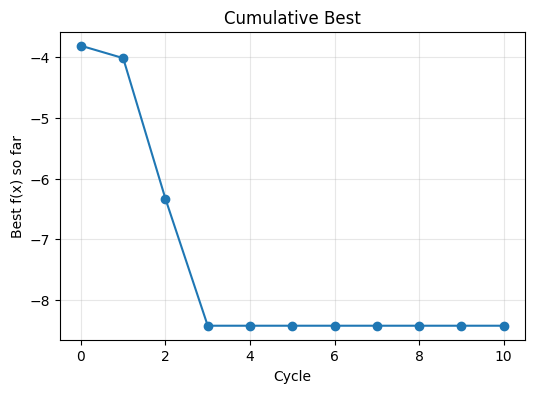

In [26]:
import matplotlib.pyplot as plt

# BFMQA を実行（主要パラメータは run_demo の説明セルを参照）
res = run_demo(
    seed=123,
    d=20,
    bb_seed=1234,

    k=5,
    n0=10,
    cycles=10,
    qubos_per_cycle=20,
    vi_iters=50000,
    vi_draws=200,
    sa_reads=100,

    sa_workers=0,      # 0 の場合は CPU 数に応じて自動設定
)

# 最終結果の表示
print("best_value:", res["best_value"])
print("best_x (binary):", res["best_x"])
print("sa_workers:", res["sa_workers"], "eval_workers:", res["eval_workers"], "parallel_eval:", res["use_parallel_eval"])

# サイクルごとの累積最良の推移をプロット
plt.figure(figsize=(6, 4))
plt.plot(res["best_hist"], marker="o")
plt.title("Cumulative Best")
plt.xlabel("Cycle")
plt.ylabel("Best f(x) so far")
plt.grid(True, alpha=0.3)
plt.show()

## `plot_all_points(res)` のグラフの見方

`plot_all_points(res)` は、BFMQAの探索過程を 1 枚の図にまとめて可視化します。  
横軸は「評価した順番」、縦軸はブラックボックスの目的関数値 $f(x)$ です。

### 線と点の意味
- **Initial points（青点列）**  
  初期データ（`n0` 個）の評価値です。  
  グラフでは見分けやすいように、横軸を負の領域（$-(n0-1)$ から $0$）に配置しています。

- **All cycle points（オレンジ点列）**  
  各サイクルで生成した候補（`qubos_per_cycle` 個 × `cycles`）の評価値です。  
  横軸は $1,2,3,\dots$ のように正の領域に並びます。

- **Best so far（緑の線）**  
  「初期点 + 全サイクル点」を評価順に見たときの **累積最良値**（その時点までの最小 $f(x)$）です。  
  この線が下がっていくほど、探索が改善していることを意味します。

### 縦の点線（サイクル境界）
- 縦の点線は **サイクルの区切り**です。  
  1サイクルあたり `qubos_per_cycle` 点追加されるので、  
  $x = m, 2m, 3m, \dots$（$m=$ `qubos_per_cycle`）の位置に境界線が引かれます。

### 何が分かるか
- **探索が進んでいるか**：`Best so far` がサイクルごとに下がるかを見る  
- **当たりサイクル/外れサイクル**：あるサイクルで点が急に低くなる（当たり）／全体的に高いまま（外れ）  
- **候補の分散**：`All cycle points` の縦方向の広がりが大きいほど、多様な候補が出ている

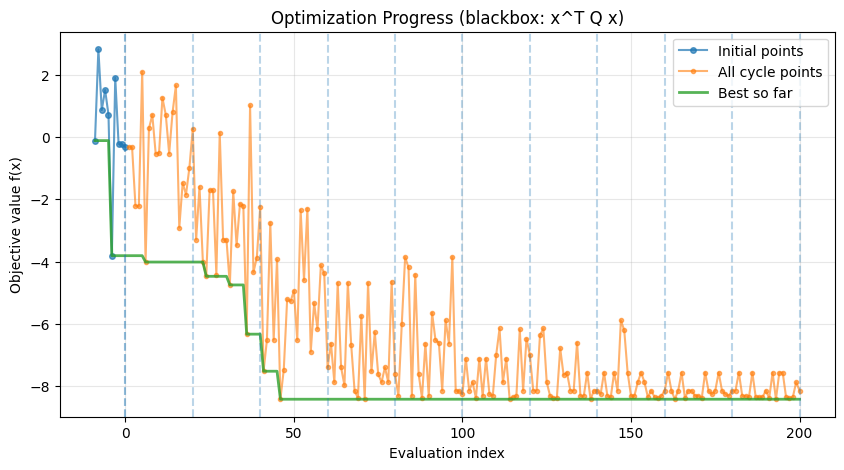

In [28]:
plot_all_points(res)